In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
import timm
import numpy as np
from tqdm.auto import tqdm
import os
import zipfile
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

C:\Users\abdul\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions."""
    return (y_true == y_pred).sum().item() / len(y_true) * 100

In [4]:
def train_step(model, data_loader, loss_fn, optimizer, accuracy_fn, device=device):
    model.train()
    train_loss, train_acc = 0, 0
    # <<< THIS LINE CREATES THE TRAINING PROGRESS BAR >>>
    progress_bar = tqdm(data_loader, desc="Training", leave=False)
    for X, y in progress_bar:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        progress_bar.set_postfix(loss=loss.item(), accuracy=f"{train_acc / (progress_bar.n + 1):.2f}%")
    return train_loss / len(data_loader), train_acc / len(data_loader)

def test_step(model, data_loader, loss_fn, accuracy_fn, device=device):
    model.eval()
    test_loss, test_acc = 0, 0
    # <<< THIS LINE CREATES THE TESTING PROGRESS BAR >>>
    progress_bar = tqdm(data_loader, desc="Testing on Sketch", leave=False)
    with torch.inference_mode():
        for X, y in progress_bar:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y).item()
            test_loss += loss
            test_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
            progress_bar.set_postfix(loss=loss, accuracy=f"{test_acc / (progress_bar.n + 1):.2f}%")
    return test_loss / len(data_loader), test_acc / len(data_loader)


In [5]:
# --- 2. PACS DATASET HANDLING ---

def download_and_extract_pacs(root="."):
    """Extracts the PACS dataset from a local zip file."""
    pacs_dir = os.path.join(root, "pacs_dataset")
    zip_path = os.path.join(root, "PACS.zip")
    if os.path.exists(pacs_dir):
        print("PACS dataset already extracted.")
        return pacs_dir
    if not os.path.exists(zip_path):
        print(f"Error: Local file '{zip_path}' not found.")
        print("Please make sure 'PACS.zip' is in the same directory as this script.")
        return None
    print(f"Found local file at '{zip_path}'. Extracting...")
    try:
        with zipfile.ZipFile(zip_path, 'r') as z:
            z.extractall(root)
        print("Extraction complete.")
    except Exception as e:
        print(f"Error extracting zip file: {e}")
        return None
    return pacs_dir

class PACSDataset(Dataset):
    """Custom Dataset for PACS."""
    def __init__(self, root_dir, domains, transform=None):
        self.root_dir = root_dir
        self.domains = domains
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_names = sorted(os.listdir(os.path.join(root_dir, domains[0])))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.class_names)}
        
        # <<< NEW: Progress bar for finding image files >>>
        for domain in tqdm(self.domains, desc=f"Scanning domains {self.domains}"):
            domain_path = os.path.join(self.root_dir, domain)
            for class_name in self.class_names:
                class_path = os.path.join(domain_path, class_name)
                for img_name in os.listdir(class_path):
                    self.image_paths.append(os.path.join(class_path, img_name))
                    self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [6]:
# --- 3. MODEL, TRANSFORMS & VISUALIZATION ---

NUM_CLASSES_PACS = 7
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

transform_suite = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

def get_models():
    cnn_pacs = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
    cnn_pacs.fc = nn.Linear(cnn_pacs.fc.in_features, NUM_CLASSES_PACS)
    vit_pacs = timm.create_model("vit_small_patch16_224", pretrained=True, num_classes=NUM_CLASSES_PACS)
    return cnn_pacs.to(device), vit_pacs.to(device)

def visualize_pacs_samples(loader, class_names, title):
    images, labels = next(iter(loader))
    unnormalize = transforms.Normalize(
        mean=[-m/s for m, s in zip(IMAGENET_MEAN, IMAGENET_STD)],
        std=[1/s for s in IMAGENET_STD]
    )
    fig, axes = plt.subplots(4, 8, figsize=(20, 10))
    fig.suptitle(title, fontsize=24)
    for i, ax in enumerate(axes.flat):
        if i >= len(images): break
        img = unnormalize(images[i]).permute(1, 2, 0).numpy().clip(0, 1)
        ax.imshow(img)
        ax.set_title(class_names[labels[i]])
        ax.axis("off")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

PACS dataset already extracted.


Scanning domains ['photo', 'art_painting', 'cartoon']:   0%|          | 0/3 [00:00<?, ?it/s]

Scanning domains ['photo', 'art_painting', 'cartoon']: 100%|██████████| 3/3 [00:00<00:00, 59.69it/s]
Scanning domains ['photo']: 100%|██████████| 1/1 [00:00<00:00, 36.76it/s]


Training on domains: ['photo', 'art_painting', 'cartoon'] (6062 images)
Testing on domain: ['sketch'] (3929 images)
Classes: ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']

Displaying sample images from a training domain ('photo')...


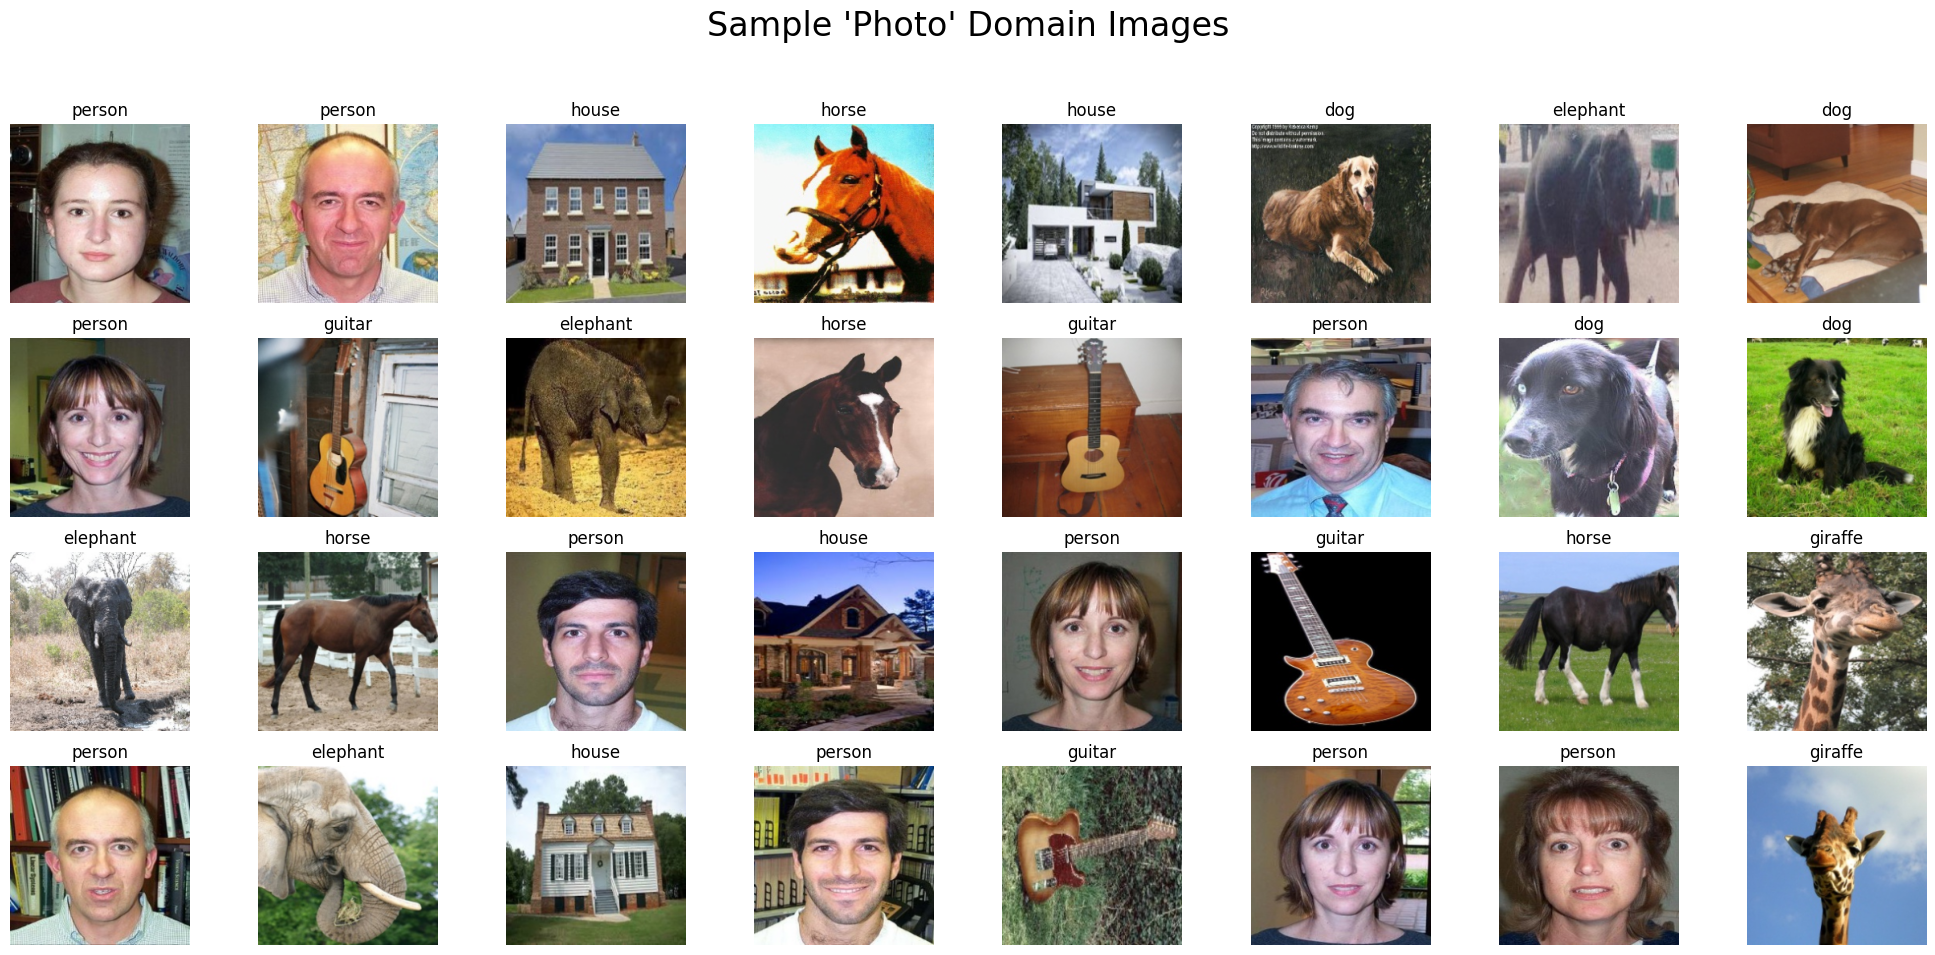


Displaying sample images from the test domain ('sketch')...


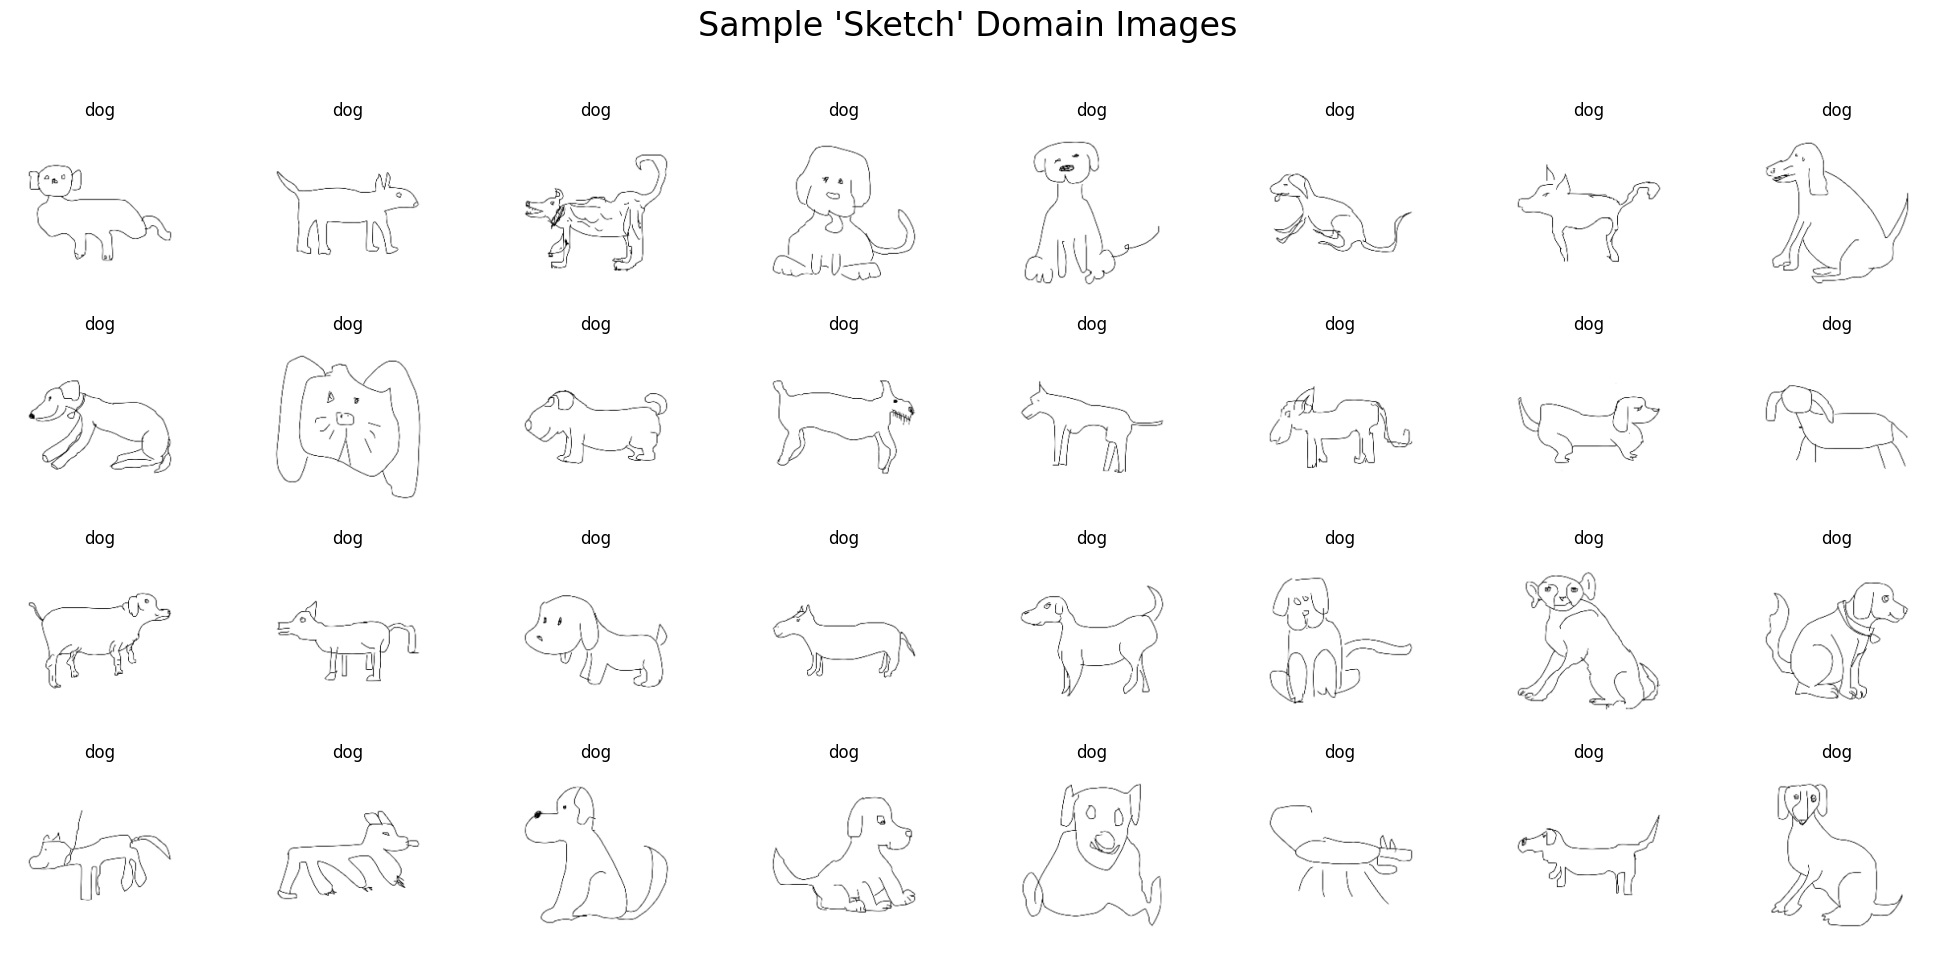


--- Epoch 1/5 ---

Fine-tuning CNN (ResNet-50)...


  CNN Train -> Loss: 0.3367, Acc: 89.31%
  CNN Test (Sketch) -> Loss: 0.8660, Acc: 68.98%

Fine-tuning ViT (ViT-S/16)...


  ViT Train -> Loss: 0.2678, Acc: 90.89%
  ViT Test (Sketch) -> Loss: 1.4315, Acc: 45.82%

--- Epoch 2/5 ---

Fine-tuning CNN (ResNet-50)...


  CNN Train -> Loss: 0.0835, Acc: 97.40%
  CNN Test (Sketch) -> Loss: 0.8571, Acc: 71.47%

Fine-tuning ViT (ViT-S/16)...


  ViT Train -> Loss: 0.0467, Acc: 98.60%
  ViT Test (Sketch) -> Loss: 1.5344, Acc: 51.95%

--- Epoch 3/5 ---

Fine-tuning CNN (ResNet-50)...


  CNN Train -> Loss: 0.0536, Acc: 98.34%
  CNN Test (Sketch) -> Loss: 0.7605, Acc: 76.10%

Fine-tuning ViT (ViT-S/16)...


  ViT Train -> Loss: 0.0307, Acc: 99.10%
  ViT Test (Sketch) -> Loss: 1.9795, Acc: 34.72%

--- Epoch 4/5 ---

Fine-tuning CNN (ResNet-50)...


  CNN Train -> Loss: 0.0559, Acc: 98.27%
  CNN Test (Sketch) -> Loss: 0.7801, Acc: 74.09%

Fine-tuning ViT (ViT-S/16)...


  ViT Train -> Loss: 0.0405, Acc: 98.75%
  ViT Test (Sketch) -> Loss: 1.3994, Acc: 53.61%

--- Epoch 5/5 ---

Fine-tuning CNN (ResNet-50)...


  CNN Train -> Loss: 0.0405, Acc: 98.76%
  CNN Test (Sketch) -> Loss: 1.1094, Acc: 72.52%

Fine-tuning ViT (ViT-S/16)...


  ViT Train -> Loss: 0.0419, Acc: 98.73%
  ViT Test (Sketch) -> Loss: 1.4611, Acc: 48.29%

--- Experiment Complete ---

Saving final models to cnn_pacs_finetuned.pth and vit_pacs_finetuned.pth...
Models saved successfully!


In [7]:
# --- 4. MAIN EXPERIMENT EXECUTION ---

if __name__ == "__main__":
    EPOCHS = 5
    LEARNING_RATE = 1e-4
    BATCH_SIZE = 32

    pacs_root = download_and_extract_pacs()
    
    if pacs_root:
        train_domains = ['photo', 'art_painting', 'cartoon']
        test_domain = ['sketch']
        photo_domain = ['photo']

        train_dataset = PACSDataset(pacs_root, domains=train_domains, transform=transform_suite)
        test_dataset = PACSDataset(pacs_root, domains=test_domain, transform=transform_suite)
        photo_dataset_viz = PACSDataset(pacs_root, domains=photo_domain, transform=transform_suite)
        
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
        photo_loader_viz = DataLoader(photo_dataset_viz, batch_size=BATCH_SIZE, shuffle=True)
        
        print(f"\nTraining on domains: {train_domains} ({len(train_dataset)} images)")
        print(f"Testing on domain: {test_domain} ({len(test_dataset)} images)")
        print(f"Classes: {train_dataset.class_names}")

        print("\nDisplaying sample images from a training domain ('photo')...")
        visualize_pacs_samples(photo_loader_viz, train_dataset.class_names, "Sample 'Photo' Domain Images")
        
        print("\nDisplaying sample images from the test domain ('sketch')...")
        visualize_pacs_samples(test_loader, test_dataset.class_names, "Sample 'Sketch' Domain Images")

        cnn_model, vit_model = get_models()
        
        loss_fn = nn.CrossEntropyLoss()
        optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=LEARNING_RATE)
        optimizer_vit = optim.AdamW(vit_model.parameters(), lr=LEARNING_RATE)

        for epoch in range(EPOCHS):
            print(f"\n--- Epoch {epoch+1}/{EPOCHS} ---")
            
            print("\nFine-tuning CNN (ResNet-50)...")
            cnn_train_loss, cnn_train_acc = train_step(cnn_model, train_loader, loss_fn, optimizer_cnn, accuracy_fn)
            cnn_test_loss, cnn_test_acc = test_step(cnn_model, test_loader, loss_fn, accuracy_fn)
            print(f"  CNN Train -> Loss: {cnn_train_loss:.4f}, Acc: {cnn_train_acc:.2f}%")
            print(f"  CNN Test (Sketch) -> Loss: {cnn_test_loss:.4f}, Acc: {cnn_test_acc:.2f}%")

            print("\nFine-tuning ViT (ViT-S/16)...")
            vit_train_loss, vit_train_acc = train_step(vit_model, train_loader, loss_fn, optimizer_vit, accuracy_fn)
            vit_test_loss, vit_test_acc = test_step(vit_model, test_loader, loss_fn, accuracy_fn)
            print(f"  ViT Train -> Loss: {vit_train_loss:.4f}, Acc: {vit_train_acc:.2f}%")
            print(f"  ViT Test (Sketch) -> Loss: {vit_test_loss:.4f}, Acc: {vit_test_acc:.2f}%")
            
        print("\n--- Experiment Complete ---")

        cnn_save_path = "cnn_pacs_finetuned.pth"
        vit_save_path = "vit_pacs_finetuned.pth"
        print(f"\nSaving final models to {cnn_save_path} and {vit_save_path}...")
        torch.save(cnn_model.state_dict(), cnn_save_path)
        torch.save(vit_model.state_dict(), vit_save_path)
        print("Models saved successfully!")